In [1]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE, colors, etc.
from faculty_hiring.misc.productivity import *
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

import numpy as np
import scipy as sp
import palettable

from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from collections import Counter

In [2]:
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Code/src/github.com/allisonmorgan/faculty_hiring/notebooks-productivity/figures/'

# Path to prepped DBLP pickles
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [3]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)  # This takes a minute..

# Total Number of Publications

In [4]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
# Set limit_by_years_post_hire flag to True to consider only the contributions within the first 5 
# years of a researcher's career.
limit_by_years_post_hire = False
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']
pubs_by_inst = {}
pubs_by_year_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []; n_pubs_by_year = [];
    for person in current_faculty:
        start = person.first_asst_job_year
        if limit_by_years_post_hire:
            end = np.min([2012, person.first_asst_job_year + 5])
        else:
            end = 2012
        career_length = end - start
        
        if person.__contains__('dblp_pubs'):
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub \
                      and pub['year'] >= start \
                      and pub['year'] < end \
                      and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            
            n_pubs.append((person.facultyName, contribution))
            n_pubs_by_year.append((person.facultyName, contribution/float(career_length)))
    if len(n_pubs) > 0:
        pubs_by_inst[name] = n_pubs
        pubs_by_year_by_inst[name] = n_pubs_by_year

In [5]:
print(pubs_by_year_by_inst['Stanford University'][0], pubs_by_inst['Stanford University'][0])

(('Alex Aiken', 6.565250679972073), ('Alex Aiken', 124.73976291946938))


In [6]:
# Plot of differences in productivity from the mean
def plot_distribution_of_productivity(data):
    diffs = []
    for (name, n_pubs) in data.items():
        counts = [np.log(pubs + 1) for _, pubs in n_pubs]
        
        avg = np.mean(counts)
        diffs.extend([(count - avg) for count in counts])
    
    print(sp.stats.mstats.normaltest(diffs))
        
    fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
    plt.hist(diffs)
    plt.show()

NormaltestResult(statistic=27.409853395514581, pvalue=1.1169300111067217e-06)


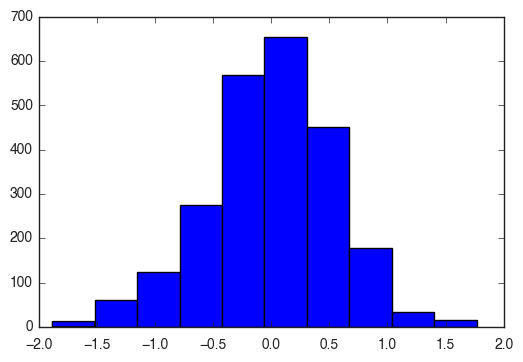

In [7]:
plot_distribution_of_productivity(pubs_by_year_by_inst)

### Prestige

The following two plots shows the median number of publications per faculty (adjusted for inflation). 
Two lines are fit through private and public university medians respectively.

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Line of best fit for private schools has a slope of -0.2787 and a r^2 of 0.4406
Line of best fit for public schools has a slope of -0.2657 and a r^2 of 0.3133


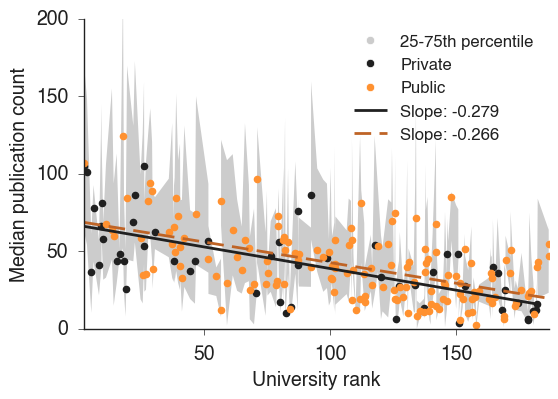

In [8]:
plot_pubs_versus_prestige(pubs_by_inst, 'Median publication count', function=np.median, percentiles=True)

# Fractional Author Contribution

In [ ]:
# Fractional contribution of publications for all current assistant faculty of a university
frac_pubs_by_inst = {};
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    frac_n_pubs = []
    for person in current_faculty:
        start = person.first_asst_job_year
        if person.__contains__('dblp_pubs'):            
            frac_contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                    frac_contribution += inflation_adjust(pub['year'])/float(len(pub['authors']))
            frac_n_pubs.append((person.facultyName, frac_contribution))
            
    if len(n_pubs) > 0:
        frac_pubs_by_inst[name] = frac_n_pubs

### Prestige

In [ ]:
plot_pubs_versus_prestige(frac_pubs_by_inst, 'Fractional Contribution', function=np.median, percentiles=True, fit=True, private=True)

# Exclude Middle Author Role From Number of Publications

In [ ]:
# Number of publications for all current assistant faculty of a university
first_and_last_pubs_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []
    for person in current_faculty:
        start = person.first_asst_job_year
        if person.__contains__('dblp_pubs'):
            first_and_last_contributions = 0
            for pub in person.dblp_pubs:
                if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                    if pub['author_role'] != 1:
                        first_and_last_contributions += inflation_adjust(pub['year'])
            n_pubs.append((person.facultyName, first_and_last_contributions))
    
    if len(n_pubs) > 0:
        first_and_last_pubs_by_inst[name] = n_pubs

### Prestige

In [ ]:
plot_pubs_versus_prestige(first_and_last_pubs_by_inst, 'Number of FAP & LAP', function=np.median, percentiles=True, fit=True, private=True)